Version: 0.0.2  Updated date: 07/05/2024
Conda Environment : py-snowpark_df_ml_fs-1.15.0_v1

# Getting Started with Snowflake Feature Store -  Customer Segmentation

The Customer segmentation (UC01) use case is designed to emulate a data science pipeline to find clusters of customers based  on  aggregate  features where  the  customers  are  grouped  based  on  their  spending behavior. <br>

It  involves  creating subgroups of customers based on similar traits. <br>

The input in this use case consists of order and return transaction data from a retail business. <br>

The use case uses Tables Customer, Order, Lineitem and Order_returns. <br>

K-means  clustering  algorithm  is  used  to  derive  the  optimum  number  of  clusters  and  understand  the  underlying customer segments based on the data provided. <br>
Clustering is an unsupervised machine learning technique, where there are no defined dependent and independent variables, i.e. the training samples are unlabeled. <br>
The pattern in the data is used to identify and group similar observations. <br>

We will use the Use-Case to show how Snowflake Feature Store (and Model Registry) can be used to maintain & store features, retrieve them for training and perform micro-batch inference.

In the development (TRAINING) enviroment we will 
- create FeatureViews in the Feature Store that maintain the required customer-behaviour features.
- use these Features to train a model, and save the model in the Snowflake model-registry.
- plot the clusters for the trained model to visually verify. 

In the production (SERVING) environment we will
- re-create the FeatureViews on production data
- generate an Inference FeatureView that uses the saved model to perform incremental inference

# Feature Engineering & Model Training

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pip install tabulate

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#### Notebook Packages

In [1]:
# Python packages
import os
from os import listdir
from os.path import isfile, join
import time
import json
import timeit
import numpy as np
import pandas as pd
import tabulate
import datetime
import ast      
import sqlglot
import sqlglot.optimizer.optimizer

# SNOWFLAKE
# Snowpark
from snowflake.snowpark import Session, DataFrame, Window, WindowSpec

import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.version import VERSION

# Snowflake Feature Store
from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode)

# Snowflake Model Registry
from snowflake.ml.registry import Registry
from snowflake.ml.utils import connection_params
from snowflake.ml._internal.utils import  identifier  

# COMMON FUNCTIONS
from useful_fns import check_and_update, formatSQL, create_ModelRegistry, create_FeatureStore 

#### Use-Case 01 - Specific Packages
# K-Means clustering
#from sklearn.pipeline import Pipeline as skl_Pipeline
from snowflake.ml.modeling.pipeline import Pipeline as sml_Pipeline
#from sklearn.preprocessing import MinMaxScaler as skl_MinMaxScaler
from snowflake.ml.modeling.preprocessing import MinMaxScaler as sml_MinMaxScaler
#from sklearn.cluster import KMeans as skl_KMeans
from snowflake.ml.modeling.cluster import KMeans as sml_KMeans

### Setup Snowflake connection and database parameters

In [3]:
# Scale Factor
scale_factor               = 'SF0001'

# Roles
fs_qs_role                 = 'RAKESHGADIPARTHI'

# Database
tpcxai_database_base       = f'TPCXAI_{scale_factor}_QUICKSTART'
tpcxai_database            = f'{tpcxai_database_base}_INC'

# Schemas
tpcxai_training_schema     = 'TRAINING'
tpcxai_scoring_schema      = 'SCORING'
tpcxai_serving_schema      = 'SERVING'

# Create Snowflake Session object
connection_parameters = connection_params.SnowflakeLoginOptions("fya62509")
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True
snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Set  Environment
session.sql(f'''use database {tpcxai_database}''').collect()
session.sql(f'''use schema {tpcxai_training_schema}''').collect()
session.sql(f'''use role {fs_qs_role}''').collect()

# Create a Warehouse
#warehouse_env = f"""{tpcxai_database}_{tpcxai_training_schema}"""
#warehouse_sz = 'MEDIUM'
warehouse_env = f'FOSFOR_INSIGHT_WH'
session.sql(f'''use warehouse {warehouse_env}''').collect()
#session.sql(f'''alter warehouse {warehouse_env} set warehouse_size = {warehouse_sz}''').collect()

# Current Environment Details
print('\nConnection Established with the following parameters:')
print(f'User                        : {snowflake_environment[0][0]}')
print(f'Role                        : {session.get_current_role()}')
print(f'Database                    : {session.get_current_database()}')
print(f'Schema                      : {session.get_current_schema()}')
print(f'Warehouse                   : {session.get_current_warehouse()}')
print(f'Snowflake version           : {snowflake_environment[0][1]}')
print(f'Snowpark for Python version : {snowpark_version[0]}.{snowpark_version[1]}.{snowpark_version[2]} \n')


Connection Established with the following parameters:
User                        : SF$SERVICE$mfU6u2k_D-0UpGPF4MnAMg
Role                        : "RAKESHGADIPARTHI"
Database                    : "TPCXAI_SF0001_QUICKSTART_INC"
Schema                      : "TRAINING"
Warehouse                   : "FOSFOR_INSIGHT_WH"
Snowflake version           : 8.28.0
Snowpark for Python version : 1.20.0 



## MODEL DEVELOPMENT
* Create Snowflake Model-Registry
* Create Snowflake Feature-Store
* Establish and Create CUSTOMER Entity in the development Snowflake FeatureStore
* Create Source Data references and perform basic data-cleansing
* Create & Run Preprocessing Function to create features
* Create FeatureView_Preprocess from Preprocess Dataframe SQL
* Create training data from FeatureView_Preprocess (asof join)
* Create & Fit Snowpark-ml pipeline 
* Save model in Model Registry
* 'Verify' and approve model
* Create new FeatureView_Model_Inference with Transforms UDF + KMeans model

In [4]:
# Set the Schema
tpcxai_schema = tpcxai_training_schema

# Create/Reference Snowflake Model Registry - Common across Environments
mr = create_ModelRegistry(session, tpcxai_database, '_MODEL_REGISTRY')

# Create/Reference Snowflake Feature Store for Training (Development) Environment
fs = create_FeatureStore(session, tpcxai_database, f'''_{tpcxai_schema}_FEATURE_STORE''', warehouse_env)

# Tables
customer_tbl                     = '.'.join([tpcxai_database, tpcxai_schema,'CUSTOMER'])
line_item_tbl                    = '.'.join([tpcxai_database, tpcxai_schema,'LINEITEM'])
order_tbl                        = '.'.join([tpcxai_database, tpcxai_schema,'ORDERS'])
order_returns_tbl                = '.'.join([tpcxai_database, tpcxai_schema,'ORDER_RETURNS'])

# Snowpark Dataframe
customer_sdf               = session.table(customer_tbl)
line_item_sdf              = session.table(line_item_tbl)
order_sdf                  = session.table(order_tbl)
order_returns_sdf          = session.table(order_returns_tbl)

# Row Counts
print(f'''\nTABLE ROW_COUNTS IN {tpcxai_schema}''')
print(customer_tbl, customer_sdf.count())
print(line_item_tbl, line_item_sdf.count())
print(order_tbl, order_sdf.count())
print(order_returns_tbl, order_returns_sdf.count())

Model Registry (_MODEL_REGISTRY) created
Feature Store (_TRAINING_FEATURE_STORE) created

TABLE ROW_COUNTS IN TRAINING
TPCXAI_SF0001_QUICKSTART_INC.TRAINING.CUSTOMER 70710
TPCXAI_SF0001_QUICKSTART_INC.TRAINING.LINEITEM 23026666
TPCXAI_SF0001_QUICKSTART_INC.TRAINING.ORDERS 3676955
TPCXAI_SF0001_QUICKSTART_INC.TRAINING.ORDER_RETURNS 1331620


### CUSTOMER Entity
Establish and Create CUSTOMER Entity in Snowflake FeatureStore for this Use-Case

In [5]:
# NOTE: adjust this when we suport "create_if_not_exists"
if "CUSTOMER" not in json.loads(fs.list_entities().select(F.to_json(F.array_agg("NAME", True))).collect()[0][0]):
    customer_entity = Entity(name="CUSTOMER", join_keys=["O_CUSTOMER_SK"],desc="Primary Key for CUSTOMER")
    fs.register_entity(customer_entity)
else:
    customer_entity = fs.get_entity("CUSTOMER")

fs.list_entities().show()

------------------------------------------------------------------------------
|"NAME"    |"JOIN_KEYS"        |"DESC"                    |"OWNER"           |
------------------------------------------------------------------------------
|CUSTOMER  |["O_CUSTOMER_SK"]  |Primary Key for CUSTOMER  |RAKESHGADIPARTHI  |
------------------------------------------------------------------------------



 ### Create & Load Source Data

Our Feature engineering pipelines are defined using Snowpark dataframes (or SQL expressions).  In the `QS_feature_engineering_fns.py` file we have created two feature engineering functions to create our pipeline :
* __uc01_load_data__(order_data: DataFrame, lineitem_data: DataFrame, order_returns_data: DataFrame) -> DataFrame   
* __uc01_pre_process__(data: DataFrame) -> DataFrame

`uc01_load_data`, takes the source tables, as dataframe objects, and joins them together, performing some data-cleansing by replacing NA's with default values. It returns a dataframe as it's output.

`uc01_pre_process`, takes the dataframe output from `uc01_load_data`  and performs aggregation on it to derive some features that will be used in our segmentation model.  It returns a dataframe as output, which we will use to provide the feature-pipeline definition within our FeatureView.

In this way we can build up a complex pipeline step-by-step and use it to derive a FeatureView, that will be maintained as a pipeline in Snowflake.

We will import the functions, and create dataframes from them using the dataframes we created earlier pointing to the tables in our TRAINING (Development) schema.  We will use the last dataframe we create at the end of the pipeline as our input to the FeatureView.


In [6]:
# Feature Engineering Functions
from feature_engineering_fns import uc01_load_data, uc01_pre_process

In [7]:
raw_data = uc01_load_data(order_sdf, line_item_sdf, order_returns_sdf)

In [8]:
# Format and print the SQL for the Snowpark Dataframe
rd_sql = formatSQL(raw_data.queries['queries'][0], True)
print(os.linesep.join(rd_sql.split(os.linesep)[:1000]))

WITH SNOWPARK_LEFT AS (
  SELECT
    "LI_ORDER_ID" AS "LI_ORDER_ID",
    "LI_PRODUCT_ID" AS "LI_PRODUCT_ID",
    "QUANTITY" AS "QUANTITY",
    "PRICE" AS "PRICE"
  FROM TPCXAI_SF0001_QUICKSTART_INC.TRAINING.LINEITEM
), SNOWPARK_RIGHT AS (
  SELECT
    "OR_ORDER_ID" AS "OR_ORDER_ID",
    "OR_PRODUCT_ID" AS "OR_PRODUCT_ID",
    "OR_RETURN_QUANTITY" AS "OR_RETURN_QUANTITY"
  FROM TPCXAI_SF0001_QUICKSTART_INC.TRAINING.ORDER_RETURNS
), cte AS (
  SELECT
    *
  FROM (
    SNOWPARK_LEFT AS SNOWPARK_LEFT
      LEFT OUTER JOIN SNOWPARK_RIGHT AS SNOWPARK_RIGHT
        ON (
          (
            "LI_ORDER_ID" = "OR_ORDER_ID"
          ) AND (
            "LI_PRODUCT_ID" = "OR_PRODUCT_ID"
          )
        )
  )
), SNOWPARK_LEFT_2 AS (
  SELECT
    "LI_ORDER_ID" AS "LI_ORDER_ID",
    "LI_PRODUCT_ID" AS "LI_PRODUCT_ID",
    "QUANTITY" AS "QUANTITY",
    "PRICE" AS "PRICE",
    "OR_ORDER_ID" AS "OR_ORDER_ID",
    "OR_PRODUCT_ID" AS "OR_PRODUCT_ID",
    "OR_RETURN_QUANTITY" AS "OR_RETURN_QUANTIT

In [9]:
raw_data.show()

-----------------------------------------------------------------------------------------------------------------
|"O_ORDER_ID"  |"O_CUSTOMER_SK"  |"ORDER_DATE"  |"LI_PRODUCT_ID"  |"PRICE"  |"QUANTITY"  |"OR_RETURN_QUANTITY"  |
-----------------------------------------------------------------------------------------------------------------
|1856548       |34195            |2021-06-29    |330              |1.66     |3           |2                     |
|1856548       |34195            |2021-06-29    |324              |7.60     |2           |2                     |
|1856548       |34195            |2021-06-29    |334              |8.57     |3           |3                     |
|1856549       |939              |2023-03-16    |365              |0.34     |2           |2                     |
|1856549       |939              |2023-03-16    |364              |2.70     |3           |2                     |
|1856549       |939              |2023-03-16    |368              |8.11     |2          

### Create & Run Preprocessing Function 

In [10]:
preprocessed_data = uc01_pre_process(raw_data)

In [11]:
# Format and print the SQL for the Snowpark Dataframe
ppd_sql = formatSQL(preprocessed_data.queries['queries'][0], True)
print(os.linesep.join(ppd_sql.split(os.linesep)[:1000]))

WITH SNOWPARK_LEFT AS (
  SELECT
    "LI_ORDER_ID" AS "LI_ORDER_ID",
    "LI_PRODUCT_ID" AS "LI_PRODUCT_ID",
    "QUANTITY" AS "QUANTITY",
    "PRICE" AS "PRICE"
  FROM TPCXAI_SF0001_QUICKSTART_INC.TRAINING.LINEITEM
), SNOWPARK_RIGHT AS (
  SELECT
    "OR_ORDER_ID" AS "OR_ORDER_ID",
    "OR_PRODUCT_ID" AS "OR_PRODUCT_ID",
    "OR_RETURN_QUANTITY" AS "OR_RETURN_QUANTITY"
  FROM TPCXAI_SF0001_QUICKSTART_INC.TRAINING.ORDER_RETURNS
), cte AS (
  SELECT
    *
  FROM (
    SNOWPARK_LEFT AS SNOWPARK_LEFT
      LEFT OUTER JOIN SNOWPARK_RIGHT AS SNOWPARK_RIGHT
        ON (
          (
            "LI_ORDER_ID" = "OR_ORDER_ID"
          ) AND (
            "LI_PRODUCT_ID" = "OR_PRODUCT_ID"
          )
        )
  )
), SNOWPARK_LEFT_2 AS (
  SELECT
    "LI_ORDER_ID" AS "LI_ORDER_ID",
    "LI_PRODUCT_ID" AS "LI_PRODUCT_ID",
    "QUANTITY" AS "QUANTITY",
    "PRICE" AS "PRICE",
    "OR_ORDER_ID" AS "OR_ORDER_ID",
    "OR_PRODUCT_ID" AS "OR_PRODUCT_ID",
    "OR_RETURN_QUANTITY" AS "OR_RETURN_QUANTIT

In [14]:
preprocessed_data.show()

-------------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"FREQUENCY"         |"RETURN_RATIO"  |"LATEST_ORDER_DATE"  |
-------------------------------------------------------------------------------
|368              |1.6666666666666667  |0.732044784     |2023-02-04           |
|56319            |2.3333333333333335  |0.802944732857  |2023-01-28           |
|5853             |3.6666666666666665  |0.683033        |2023-02-08           |
|11318            |3.0                 |0.727960913333  |2022-09-16           |
|40668            |4.0                 |0.698579715     |2022-12-01           |
|36179            |1.0                 |0.417155313333  |2023-02-09           |
|26232            |2.3333333333333335  |0.796042062857  |2023-02-02           |
|28150            |1.0                 |0.91160669      |2023-01-08           |
|23733            |2.0                 |0.860964901667  |2023-02-09           |
|4469             |4.0                 |

### Create Preprocessing FeatureView from Preprocess Dataframe (SQL)

In [12]:
# Define descriptions for the FeatureView's Features.  These will be added as comments to the database object
preprocess_features_desc = {  "FREQUENCY":"Average yearly order frequency",
                              "RETURN_RATIO":"Average of, Per Order Returns Ratio.  Per order returns ratio : total returns value / total order value" }

ppd_fv_name    = "FV_UC01_PREPROCESS"
ppd_fv_version = "V_1"

try:
   # If FeatureView already exists just return the reference to it
   fv_uc01_preprocess = fs.get_feature_view(name=ppd_fv_name,version=ppd_fv_version)
except:
   # Create the FeatureView instance
   fv_uc01_preprocess_instance = FeatureView(
      name=ppd_fv_name, 
      entities=[customer_entity], 
      #feature_df=preprocessed_data,      # <- We can use the snowpark dataframe as-is from our Python
      feature_df=session.sql(ppd_sql),    # <- Or we can use SQL, in this case linted from the dataframe generated SQL to make more human readable
      timestamp_col="LATEST_ORDER_DATE",
      refresh_freq="60 minute",            # <- specifying optional refresh_freq creates FeatureView as Dynamic Table, else created as View.
      desc="Features to support Use Case 01").attach_feature_desc(preprocess_features_desc)

   # Register the FeatureView instance.  Creates  object in Snowflake
   fv_uc01_preprocess = fs.register_feature_view(
      feature_view=fv_uc01_preprocess_instance, 
      version=ppd_fv_version, 
      block=True
   )
   print(f"Feature View : {ppd_fv_name}_{ppd_fv_version} created")   
else:
   print(f"Feature View : {ppd_fv_name}_{ppd_fv_version} already created")
finally:
   fs.list_feature_views().show(20)

/opt/conda/lib/python3.9/site-packages/snowflake/ml/feature_store/feature_store.py:1066: UserWarning: Your pipeline won't be incrementally refreshed due to: "This dynamic table contains a complex query. Refresh mode has been set to FULL. If you wish to override this automatic choice, please re-create the dynamic table and specify REFRESH_MODE=INCREMENTAL. For best results, we recommend reading https://docs.snowflake.com/user-guide/dynamic-table-performance-guide before setting the refresh mode to INCREMENTAL.". It will likely incurr higher cost.
  self._check_dynamic_table_refresh_mode(feature_view_name)


Feature View : FV_UC01_PREPROCESS_V_1 created
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"NAME"              |"VERSION"  |"DATABASE_NAME"               |"SCHEMA_NAME"            |"CREATED_ON"                |"OWNER"           |"DESC"                           |"ENTITIES"    |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|FV_UC01_PREPROCESS  |V_1        |TPCXAI_SF0001_QUICKSTART_INC  |_TRAINING_FEATURE_STORE  |2024-08-02 08:31:04.167000  |RAKESHGADIPARTHI  |Features to support Use Case 01  |[             |
|                    |           |                              |                         |                            |                  |                                 |  "CUSTOMER"  |
|        

In [13]:
# You can also use the following to retrieve a Feature View instance for use within Python
FV_UC01_PREPROCESS_V_1 = fs.get_feature_view(ppd_fv_name, 'V_1')
# and show it's definition.  Note the formatted SQL.
FV_UC01_PREPROCESS_V_1.to_df(session).show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"NAME"              |"ENTITIES"                               |"TIMESTAMP_COL"    |"DESC"                           |"QUERY"                                             |"VERSION"  |"STATUS"                  |"FEATURE_DESC"                                      |"REFRESH_FREQ"  |"DATABASE"                    |"SCHEMA"                 |"WAREHOUSE"        |"REFRESH_MODE"  |"REFRESH_MODE_REASON"                               |"OWNER"           |"PHYSICAL_NAME"         |
--------------------------------------------------------

In [14]:
FV_UC01_PREPROCESS_V_1.to_df(session).show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"NAME"              |"ENTITIES"                               |"TIMESTAMP_COL"    |"DESC"                           |"QUERY"                                             |"VERSION"  |"STATUS"                  |"FEATURE_DESC"                                      |"REFRESH_FREQ"  |"DATABASE"                    |"SCHEMA"                 |"WAREHOUSE"        |"REFRESH_MODE"  |"REFRESH_MODE_REASON"                               |"OWNER"           |"PHYSICAL_NAME"         |
--------------------------------------------------------

In [15]:
# We can look at the FeatureView's contents with
fv_uc01_preprocess.feature_df.show()

-------------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"FREQUENCY"         |"RETURN_RATIO"  |"LATEST_ORDER_DATE"  |
-------------------------------------------------------------------------------
|46656            |2.6666666666666665  |0.672795735     |2023-02-07           |
|30475            |1.5                 |0.832431946667  |2022-10-28           |
|11843            |3.6666666666666665  |0.705347877273  |2023-04-13           |
|44728            |2.3333333333333335  |0.784137047143  |2023-03-30           |
|28286            |3.3333333333333335  |0.6300345       |2023-04-04           |
|50800            |1.5                 |0.849261753333  |2022-06-11           |
|23469            |2.3333333333333335  |0.781647795714  |2023-02-11           |
|65227            |2.6666666666666665  |0.8256317975    |2023-02-08           |
|29429            |3.6666666666666665  |0.893679678182  |2023-04-07           |
|45375            |2.0                 |

### Create training data Dataset from FeatureView_Preprocess

In [16]:
# Create Spine
spine_sdf =  fv_uc01_preprocess.feature_df.group_by('O_CUSTOMER_SK').agg( F.max('LATEST_ORDER_DATE').as_('ASOF_DATE'))#.limit(10)

spine_sdf.sort('O_CUSTOMER_SK').show(5)


---------------------------------
|"O_CUSTOMER_SK"  |"ASOF_DATE"  |
---------------------------------
|0                |2023-04-13   |
|1                |2023-01-11   |
|2                |2023-02-02   |
|3                |2023-03-29   |
|4                |2022-11-03   |
---------------------------------



In [17]:
# Generate_Dataset
training_dataset = fs.generate_dataset( name = 'UC01_TRAINING',
                                        spine_df = spine_sdf, features = [fv_uc01_preprocess], 
                                        spine_timestamp_col = 'ASOF_DATE'
                                        )                                     
# Create a snowpark dataframe reference from the Dataset
training_dataset_sdf = training_dataset.read.to_snowpark_dataframe()
# Display some sample data
training_dataset_sdf.sort('O_CUSTOMER_SK').show(5)


---------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"ASOF_DATE"  |"FREQUENCY"         |"RETURN_RATIO"      |
---------------------------------------------------------------------------
|0                |2023-04-13   |1.6666666269302368  |0.7006146907806396  |
|1                |2023-01-11   |2.3333332538604736  |0.8004919290542603  |
|2                |2023-02-02   |1.6666666269302368  |0.6384019255638123  |
|3                |2023-03-29   |2.0                 |0.6914749145507812  |
|4                |2022-11-03   |3.5                 |0.6873698234558105  |
---------------------------------------------------------------------------



In [18]:
training_dataset_sdf.to_pandas()

,O_CUSTOMER_SK,ASOF_DATE,FREQUENCY,RETURN_RATIO
0,58921,2023-04-13,1.666667,0.687267
1,59533,2023-04-14,1.333333,0.819411
2,24244,2023-04-27,2.500000,0.945463
3,65857,2023-03-10,2.666667,0.692029
4,70070,2023-02-24,1.333333,0.872989
...,...,...,...,...
70310,68030,2022-07-14,3.000000,0.956492
70311,6640,2023-01-12,2.666667,0.694223
70312,54103,2022-12-26,3.000000,0.782166
70313,48137,2023-03-23,1.333333,0.768902


In [19]:
print(training_dataset.list_versions())
print(training_dataset.selected_version)
print(training_dataset.fully_qualified_name)

['2024_08_02_08_33_08']
DatasetVersion(dataset='TPCXAI_SF0001_QUICKSTART_INC._TRAINING_FEATURE_STORE.UC01_TRAINING', version='2024_08_02_08_33_08')
TPCXAI_SF0001_QUICKSTART_INC._TRAINING_FEATURE_STORE.UC01_TRAINING


In [20]:
training_dataset.list_versions()[-1]

'2024_08_02_08_33_08'

In [21]:
# Get the latest version
training_dataset_latest = training_dataset.list_versions()[-1]

In [22]:
training_dataset.read.to_pandas()

,O_CUSTOMER_SK,ASOF_DATE,FREQUENCY,RETURN_RATIO
0,62173,2023-02-02,2.500000,0.653662
1,13617,2022-06-28,1.000000,0.938136
2,9238,2023-01-06,2.000000,0.741761
3,36332,2023-02-04,1.666667,0.699700
4,30111,2022-11-03,2.000000,0.781601
...,...,...,...,...
70310,26723,2023-02-08,3.000000,0.854260
70311,67166,2022-11-10,1.500000,0.545169
70312,35819,2023-04-06,2.000000,0.713374
70313,69290,2022-11-09,2.000000,0.715730


### Fit Snowpark-ML Transforms & Model using Fileset training data

We need to fit the transformer over the training Fileset to ensure we are using the same input global values for transforming and training, and later inference with the model.

The transforms here are model-specific and persisted within the model-pipeline, and not stored in the Feature Store.

In [23]:
## MODEL PIPELINE 
## - Model Specific Transforms
## - Model Fitting Function (Kmeans)

def uc01_train(featurevector, num_clusters):
    mms_input_cols = ['RETURN_RATIO', 'FREQUENCY']
    km_input_cols = mms_output_cols =['RETURN_RATIO_MMS', 'FREQUENCY_MMS']    
    km_output_cols = "CLUSTER"
    km4_purchases = sml_Pipeline(
        steps=[ ("MMS",
                    sml_MinMaxScaler(
                        clip=True,
                        input_cols=mms_input_cols,
                        output_cols=mms_output_cols,)),
                ("KM",
                    sml_KMeans(
                        n_clusters=num_clusters,
                        init='k-means++',
                        max_iter=300,
                        n_init=10,
                        random_state=0,
                        input_cols=km_input_cols,
                        output_cols = km_output_cols)),])
    km4_purchases.fit(featurevector.select(mms_input_cols))
    return {'MODEL': km4_purchases}

In [24]:
## Fit the KMeans Model
model_name = "UC01_SNOWFLAKEML_KMEANS_MODEL"

num_clusters = 5

train_result = uc01_train(training_dataset_sdf, num_clusters)#

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
# Check for the latest version of this model in registry, and increment version
mr_df = mr.show_models()
model_version = check_and_update(mr_df, model_name)
print('model version:\t',model_version)
# Save the Model to the Model Registry
mv_kmeans = mr.log_model(model= train_result['MODEL'],
                model_name= model_name,
                version_name= model_version,
                comment="TPCXAI USE CASE 01 - KMEANS - CUSTOMER PURCHASE CLUSTERS"
                )

model version:	 V_1


/opt/conda/lib/python3.9/contextlib.py:119: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


In [26]:
mr.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2024-08-02 08:36:00.350000+00:00,UC01_SNOWFLAKEML_KMEANS_MODEL,USER_MODEL,TPCXAI_SF0001_QUICKSTART_INC,_MODEL_REGISTRY,None,RAKESHGADIPARTHI,V_1,"[""V_1""]","{""DEFAULT"":""V_1"",""FIRST"":""V_1"",""LAST"":""V_1""}"


In [27]:
# Get and set default for latest version of the model
m = mr.get_model(model_name)
latest_version = m.show_versions().iloc[-1]['name']
mv = m.version(latest_version)
m.default = latest_version

#### Check the model clusters

We will check the model clusters derived from the model.  We create an inference Function using the Snowflake Model Registry.  This packages our model as a Python function which enables access from [Python](https://docs.snowflake.com/developer-guide/snowpark-ml/model-registry/overview#calling-model-methods) or directly from [SQL](https://docs.snowflake.com/sql-reference/commands-model#label-snowpark-model-registry-model-methods).  This allows the model to be used directly for prediction within our Feature Engineering pipeline, by creating an inference Feature View.

In [28]:
def uc01_serve(featurevector, km4_purchases) -> DataFrame :
    clusters = km4_purchases.run(featurevector, function_name="predict")    
    return clusters

In [29]:
# Create Spine
inference_spine_sdf =  fv_uc01_preprocess.feature_df.group_by('O_CUSTOMER_SK').agg(F.max('LATEST_ORDER_DATE').as_('ASOF_DATE'))

# Generate_Dataset
inference_dataset_sdf = fs.retrieve_feature_values(spine_df = inference_spine_sdf, features = [fv_uc01_preprocess],  spine_timestamp_col = 'ASOF_DATE' )
#inference_dataset_sdf = fs.read_feature_view(fv_uc01_preprocess)

start = timeit.default_timer()#
# serve_result = uc01_serve(training_dataset_sdf, train_result['MODEL'])#
inference_result_sdf = uc01_serve(inference_dataset_sdf, mv)#
end = timeit.default_timer()#
serve_time = end - start#
print('serve time:\t', serve_time)#

inference_sample_sdf = inference_result_sdf.sample(n = 10000)
inference_sample_sdf.show()

serve time:	 0.38415953899675515
-------------------------------------------------------------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"ASOF_DATE"  |"FREQUENCY"         |"RETURN_RATIO"  |"RETURN_RATIO_MMS"   |"FREQUENCY_MMS"      |"CLUSTER"  |
-------------------------------------------------------------------------------------------------------------------------------
|38324            |2023-04-30   |4.0                 |0.837840646667  |0.35988544078198303  |0.30000000000000004  |4          |
|11705            |2023-03-08   |1.0                 |0.542917393333  |0.19348245898158556  |0.0                  |1          |
|39856            |2023-04-25   |1.6666666666666667  |0.717957314     |0.2922443043220998   |0.06666666666666668  |1          |
|34606            |2022-10-11   |3.0                 |0.765645646667  |0.31915123913707416  |0.20000000000000004  |0          |
|67019            |2022-12-15   |1.5                 |0.858476883333  |

In [30]:
#Getting unique labels
import matplotlib.pyplot as plt

u_labels = inference_sample_sdf.select(F.array_agg(F.col("CLUSTER"), is_distinct = True).alias("U_LABELS")) \
                .select(F.array_sort(F.col("U_LABELS")).cast(T.StringType()).alias("U_LABELS")).collect()[0][0]

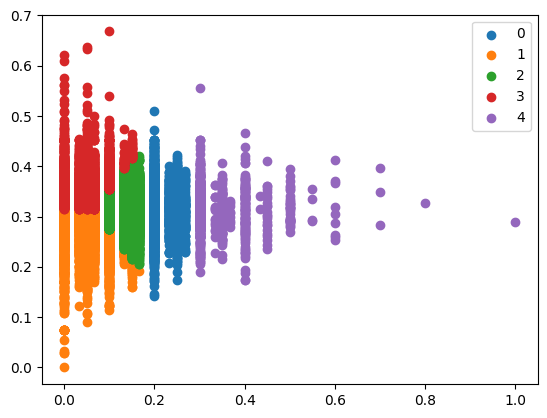

In [31]:
u_labels_lst = json.loads(u_labels)
plt_df = inference_sample_sdf.select(F.col("CLUSTER"), F.col("FREQUENCY_MMS"), F.col("RETURN_RATIO_MMS")).to_pandas()

#plotting the results:
for i in u_labels_lst:
    plt.scatter(plt_df[plt_df['CLUSTER'] == i][['FREQUENCY_MMS']]  , plt_df[plt_df['CLUSTER'] == i][['RETURN_RATIO_MMS']]  , label = i)
plt.legend()
plt.show()

We can look at the query that contains our inference function.  It makes use of the SQL API for Model registry to call the inference function `MODEL_VERSION_ALIAS!PREDICT(RETURN_RATIO, FREQUENCY) AS TMP_RESULT`

In [32]:

ind_sql = inference_result_sdf.queries['queries'][0]
ind_fmtd_sql = os.linesep.join(ind_sql.split(os.linesep)[:1000])
print(ind_fmtd_sql)

SELECT "O_CUSTOMER_SK", "ASOF_DATE", "FREQUENCY", "RETURN_RATIO",  CAST ("TMP_RESULT"['RETURN_RATIO_MMS'] AS DOUBLE) AS "RETURN_RATIO_MMS",  CAST ("TMP_RESULT"['FREQUENCY_MMS'] AS DOUBLE) AS "FREQUENCY_MMS",  CAST ("TMP_RESULT"['CLUSTER'] AS BIGINT) AS "CLUSTER" FROM (WITH SNOWPARK_ML_MODEL_INFERENCE_INPUT AS (SELECT
                            l_0.*,

                            r_0.* EXCLUDE (O_CUSTOMER_SK, LATEST_ORDER_DATE)
                        FROM (SELECT "O_CUSTOMER_SK", max("LATEST_ORDER_DATE") AS "ASOF_DATE" FROM (WITH SNOWPARK_LEFT AS (
  SELECT
    "LI_ORDER_ID" AS "LI_ORDER_ID",
    "LI_PRODUCT_ID" AS "LI_PRODUCT_ID",
    "QUANTITY" AS "QUANTITY",
    "PRICE" AS "PRICE"
  FROM TPCXAI_SF0001_QUICKSTART_INC.TRAINING.LINEITEM
), SNOWPARK_RIGHT AS (
  SELECT
    "OR_ORDER_ID" AS "OR_ORDER_ID",
    "OR_PRODUCT_ID" AS "OR_PRODUCT_ID",
    "OR_RETURN_QUANTITY" AS "OR_RETURN_QUANTITY"
  FROM TPCXAI_SF0001_QUICKSTART_INC.TRAINING.ORDER_RETURNS
), cte AS (
  SELECT
    *
  FROM (


## CLEAN UP

In [36]:
session.close()